In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,  accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.linear_model import Lasso,ElasticNet,LassoLarsIC,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, median_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [6]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.3 MB/s eta 0:00:00


In [7]:
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

In [8]:
data = pd.read_csv('/content/drive/MyDrive/BA - Project 2/Data/CDNow')
data

,id,zone,state,gender,age_category,age,date,cds,amt
0,1,Pacific,Oregon,M,young,26,1997-01-01,1,11.77
1,2,Eastern,New Jersey,M,medium,36,1997-01-12,1,12.00
2,2,Eastern,New Jersey,M,medium,36,1997-01-12,5,77.00
3,3,Central,Minnesota,M,young,17,1997-01-02,2,20.76
4,3,Central,Minnesota,M,young,17,1997-03-30,2,20.76
...,...,...,...,...,...,...,...,...,...
69654,23568,Eastern,New Jersey,F,medium,44,1997-04-05,4,83.74
69655,23568,Eastern,New Jersey,F,medium,44,1997-04-22,1,14.99
69656,23569,Mountain,Utah,M,old,63,1997-03-25,2,25.74
69657,23570,Central,Illinois,F,young,21,1997-03-25,3,51.12


In [9]:
demo = data[['id', 'zone', 'state', 'gender', 'age_category', 'age']]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            69659 non-null  int64  
 1   zone          69659 non-null  object 
 2   state         69659 non-null  object 
 3   gender        69659 non-null  object 
 4   age_category  67509 non-null  object 
 5   age           69659 non-null  int64  
 6   date          69659 non-null  object 
 7   cds           69659 non-null  int64  
 8   amt           69659 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 4.8+ MB


In [10]:
df = data.copy()

In [11]:
df = data.drop_duplicates()

df['date'] = pd.to_datetime(df['date'])
df= df[(df['cds'] > 0)]

# use only required columns for CLTV
# df = df[['Customer ID', 'InvoiceDate', 'StockCode', 'Quantity', 'Price', 'Country']]

# calculate total purchase
df['TotalPurchase'] = df['cds'] * df['amt']

# perform aggregate operations
df_grp = df.groupby('id').agg({
    'date': lambda date: (date.max() - date.min()).days,
    'cds': lambda quantity: quantity.sum(),
    'TotalPurchase': lambda total_pur: total_pur.sum()
})


# Calculate Average Order Value
df_grp['avg_order_val'] = df_grp['TotalPurchase'] / df_grp['cds']

# Calculate Purchase Frequency
purchase_frequency = df_grp.groupby('id')['cds'].count()/df_grp.shape[0]

# Calculate Repeat and Churn Rate
orders_per_customer = df_grp.groupby('id')['cds'].count()

repeat_customers = (orders_per_customer > 1).sum()

# Finally, calculate the repeat customer rate
repeat_rate = repeat_customers / df_grp.shape[0]

churn_rate = 1 - repeat_rate

# print(purchase_frequency, repeat_rate, churn_rate)

# Calculate Profit margin assuming gain of 5%
df_grp['profit_margin'] = df_grp['TotalPurchase'] * 0.05

# Calculate Customer Lifetime Value
df_grp['cust_lifetime_value'] = ((df_grp['avg_order_val'] * purchase_frequency)/churn_rate) * \
                                     df_grp['profit_margin']



df['month_yr'] = df['date'].apply(lambda x: x.strftime('%b-%Y'))

sale = df.pivot_table(index=['id'], columns=['month_yr'], values='TotalPurchase', aggfunc='sum', fill_value=0).reset_index()
sale['CLV'] = sale.iloc[:, 2:].sum(axis=1)


In [ ]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        23570 non-null  int64  
 1   Apr-1997  23570 non-null  float64
 2   Apr-1998  23570 non-null  float64
 3   Aug-1997  23570 non-null  float64
 4   Dec-1997  23570 non-null  float64
 5   Feb-1997  23570 non-null  float64
 6   Feb-1998  23570 non-null  float64
 7   Jan-1997  23570 non-null  float64
 8   Jan-1998  23570 non-null  float64
 9   Jul-1997  23570 non-null  float64
 10  Jun-1997  23570 non-null  float64
 11  Jun-1998  23570 non-null  float64
 12  Mar-1997  23570 non-null  float64
 13  Mar-1998  23570 non-null  float64
 14  May-1997  23570 non-null  float64
 15  May-1998  23570 non-null  float64
 16  Nov-1997  23570 non-null  float64
 17  Oct-1997  23570 non-null  float64
 18  Sep-1997  23570 non-null  float64
 19  CLV       23570 non-null  float64
dtypes: float64(19), int64(1)
mem

In [21]:
sale1 = pd.merge(demo, sale, on='id')

In [22]:
sale1 = pd.get_dummies(sale1)


In [12]:
X = sale.drop(['CLV', 'id'], axis=1)
y = sale[['CLV']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X = sale1.drop(['CLV', 'id'], axis=1)
y = sale1[['CLV']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model

In [13]:
names = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "GradientBoost",
    "LightGBM",
    "CatBoost"
]

models = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    xgb.XGBRegressor(),
    GradientBoostingRegressor(n_estimators=1000),
    lgb.LGBMRegressor(),
    CatBoostRegressor(iterations = 100,
            learning_rate = 0.05,
            eval_metric = "R2",
            verbose = False)
]

In [14]:
def score(X_train, X_test, y_train, y_test, names = names, models = models):
    score_df, score_test = pd.DataFrame(), []
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        medae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        score_test.append({
            'Regressor': model.__class__.__name__,
            'R2': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MEDAE': medae,
        })



    score_df = pd.DataFrame(score_test)
    score_df.sort_values(by='R2', ascending=False, inplace=True)
    return score_df

# NO DEMOGRAPHIC

In [15]:
score_df = score(X_train, X_test, y_train, y_test, names = names, models = models)
score_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 18856, number of used features: 18
[LightGBM] [Info] Start training from score 445.192333


,Regressor,R2,MAE,MSE,RMSE,MEDAE
0,LinearRegression,1.000000,3.324300e-13,3.121404e-24,1.766750e-12,6.927792e-14
4,GradientBoostingRegressor,0.584136,9.476282e+01,4.061401e+06,2.015292e+03,4.881526e+00
5,LGBMRegressor,0.484621,1.382845e+02,5.033284e+06,2.243498e+03,7.989538e+00
3,XGBRegressor,0.471019,1.381396e+02,5.166129e+06,2.272912e+03,6.860413e+00
2,RandomForestRegressor,0.468991,1.378211e+02,5.185936e+06,2.277265e+03,5.203500e-01
1,DecisionTreeRegressor,0.344699,2.187731e+02,6.399790e+06,2.529781e+03,1.800000e-01
6,CatBoostRegressor,0.273945,3.033748e+02,7.090783e+06,2.662852e+03,1.536184e+02


In [18]:
regressor_names =  ['LR', 'GRB', 'LGBM', 'XGB', 'RF', 'DT', 'CatBoost']
r2_scores = score_df.iloc[:, 1]

Text(0.5, 1.0, 'Regressor R2 Scores without demographic info')

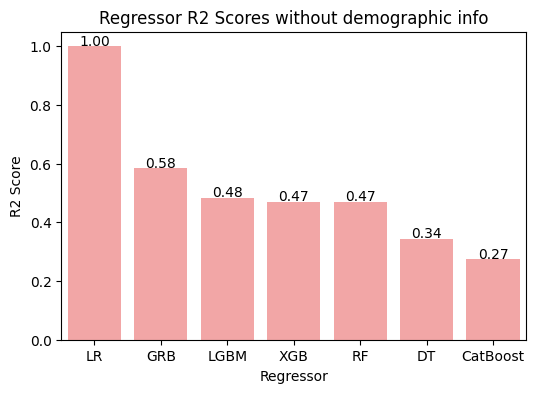

In [20]:
plt.figure(figsize=(6,4))
chart = sns.barplot(x=regressor_names, y=r2_scores, color = '#ff9999')
for i, v in enumerate(r2_scores):
    chart.text(i, v + 0.005, '{:.2f}'.format(v), ha="center")
chart.set(xlabel="Regressor", ylabel="R2 Score")
chart.set_title("Regressor R2 Scores without demographic info")

# ADD DEMOGRAPHIC

In [24]:
score_df = score(X_train, X_test, y_train, y_test, names = names, models = models)
score_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4732
[LightGBM] [Info] Number of data points in the train set: 55727, number of used features: 77
[LightGBM] [Info] Start training from score 2182.182774


,Regressor,R2,MAE,MSE,RMSE,MEDAE
0,LinearRegression,1.000000,2.195761e-12,5.420061e-23,7.362106e-12,6.821210e-13
4,GradientBoostingRegressor,0.999958,3.154793e+01,3.746782e+03,6.121096e+01,1.582883e+01
1,DecisionTreeRegressor,0.999882,3.589418e+00,1.058404e+04,1.028788e+02,0.000000e+00
3,XGBRegressor,0.999845,3.019992e+01,1.386258e+04,1.177395e+02,1.487908e+01
2,RandomForestRegressor,0.999839,9.003824e+00,1.438535e+04,1.199389e+02,3.060000e-02
5,LGBMRegressor,0.995420,9.037253e+01,4.091690e+05,6.396632e+02,3.206026e+01
6,CatBoostRegressor,0.994658,2.790080e+02,4.772642e+05,6.908431e+02,1.766007e+02


In [25]:
regressor_names =  ['LR', 'GRB', 'DT', 'XGB', 'RF', 'LGBM', 'CatBoost']
r2_scores = score_df.iloc[:, 1]

Text(0.5, 1.0, 'Regressor R2 Scores with demographic info')

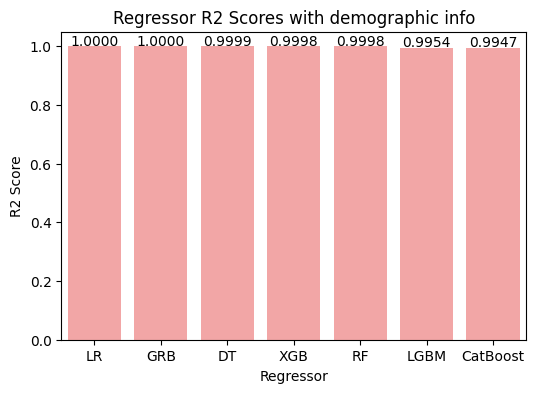

In [27]:
plt.figure(figsize=(6,4))
chart = sns.barplot(x=regressor_names, y=r2_scores, color = '#ff9999')
for i, v in enumerate(r2_scores):
    chart.text(i, v + 0.005, '{:.4f}'.format(v), ha="center")
chart.set(xlabel="Regressor", ylabel="R2 Score")
chart.set_title("Regressor R2 Scores with demographic info")